### Building a Model To predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , quarter of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Number of emails sent in each subject
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [1]:
#importing libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")

In [3]:
df.columns = df.columns.str.strip()

In [4]:
columns_to_drop = [ "translation", "CTR clean %","Month","Subject"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sent_Date          1279 non-null   object 
 1   Day_of_week        1279 non-null   object 
 2   Category_name      1279 non-null   object 
 3   Main_Vs_REM        1279 non-null   object 
 4   Sendings           1279 non-null   int64  
 5   OR                 1279 non-null   float64
 6   Length_Of_subject  1279 non-null   int64  
 7   Personalization    1279 non-null   int64  
 8   Emoji              1279 non-null   int64  
 9   Urgency            1279 non-null   int64  
 10  Tone               1279 non-null   int64  
 11  Price_or_Discount  1279 non-null   int64  
 12  Imperative_Tone    1279 non-null   int64  
 13  Product            1279 non-null   int64  
 14  Letter_Count       1279 non-null   int64  
dtypes: float64(1), int64(10), object(4)
memory usage: 150.0+ KB


In [6]:
# Convert to datetime
df['Sent_Date'] = pd.to_datetime(df['Sent_Date'], errors='coerce')

# Create a Month column (numeric)
df['Month'] = df['Sent_Date'].dt.month


In [7]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Replace numeric month values with names
df["Month"] = df["Month"].map(month_map)





In [8]:
df.columns

Index(['Sent_Date', 'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Sendings',
       'OR', 'Length_Of_subject', 'Personalization', 'Emoji', 'Urgency',
       'Tone', 'Price_or_Discount', 'Imperative_Tone', 'Product',
       'Letter_Count', 'Month'],
      dtype='object')

In [9]:
categorical_columns = [
    'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month'
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


In [10]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})


# Quick check
print(df[cols_to_replace].head())
print(df["Length_Of_subject"].head())



  Personalization Emoji Urgency Tone Price_or_Discount Imperative_Tone Product
0              no    no      no   no               yes              no     yes
1              no    no      no   no                no              no     yes
2              no   yes      no  yes                no              no      no
3              no   yes     yes  yes               yes              no      no
4              no    no      no   no               yes              no     yes
0    short
1    short
2    short
3     long
4    short
Name: Length_Of_subject, dtype: category
Categories (2, object): ['long', 'short']


Next , I will confirm that the values in "OR clean %" is a valid percentage 

In [11]:
# Check if all values are between 0 and 1
valid_percentage = df['OR'].between(0, 1).all()

if valid_percentage:
    print("All values in 'OR' are valid percentages (0 to 1).")
else:
    # Show which rows are invalid
    invalid_rows = df[~df['OR'].between(0, 1)]
    print("Some values are outside 0 to 1:")
    display(invalid_rows)


All values in 'OR' are valid percentages (0 to 1).


In [12]:
import pandas as pd
import numpy as np
from scipy import stats

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict

# Example usage
outliers = get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3)

print("Outliers in 'Sendings':")
display(outliers['Sendings'])

print("Outliers in 'OR%':")
display(outliers['OR'])


Outliers in 'Sendings':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
787,2024-12-10,Sunday,NL Interval,MAIN,241155,0.0706,short,no,no,yes,no,yes,no,yes,30,December
846,2024-11-19,Sunday,NL Interval,MAIN,239688,0.0724,short,no,no,yes,no,yes,no,yes,30,November
869,2024-11-15,Wednesday,NL Interval,MAIN,239832,0.0811,short,no,no,no,yes,yes,yes,yes,33,November
870,2024-11-24,Friday,NL Interval,MAIN,241218,0.0694,short,no,no,no,no,yes,no,yes,30,November
885,2024-11-29,Wednesday,NL Interval,MAIN,241500,0.0815,short,no,no,yes,yes,yes,yes,yes,28,November
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-11-10,Friday,NL Interval,MAIN,239778,0.0758,short,no,yes,no,yes,yes,no,yes,38,November
1258,2024-10-20,Friday,NL Interval,MAIN,239931,0.0760,short,no,yes,no,yes,yes,no,yes,38,October
1261,2024-11-01,Wednesday,NL Interval,MAIN,239781,0.0790,short,no,yes,yes,yes,yes,no,yes,30,November
1268,2024-08-25,Friday,NL Interval,MAIN,237564,0.0637,short,no,no,yes,no,yes,no,yes,28,August


Outliers in 'OR%':


,Sent_Date,Day_of_week,Category_name,Main_Vs_REM,Sendings,OR,Length_Of_subject,Personalization,Emoji,Urgency,Tone,Price_or_Discount,Imperative_Tone,Product,Letter_Count,Month
1,2024-08-02,Wednesday,NL Interval,MAIN,246,0.2927,short,no,no,no,no,no,no,yes,42,August
10,2024-11-01,Wednesday,NL Interval,MAIN,339,0.2566,short,no,yes,no,yes,yes,no,no,26,November
22,2024-07-02,Sunday,NL Interval,MAIN,315,0.2571,short,no,no,no,no,yes,no,yes,25,July
36,2024-12-03,Sunday,NL Interval,MAIN,345,0.2609,short,no,no,no,no,no,no,yes,42,December
37,2024-07-02,Sunday,NL Interval,MAIN,279,0.2581,short,no,no,no,no,no,no,yes,43,July
68,2024-03-01,Wednesday,NL Interval,MAIN,228,0.2763,short,no,no,no,no,no,no,yes,42,March
108,2024-03-01,Wednesday,NL Interval,MAIN,300,0.3200,short,no,no,no,no,no,no,yes,43,March
124,2024-03-22,Wednesday,NL Interval,MAIN,1188,0.3157,short,no,yes,yes,yes,yes,no,yes,30,March
317,2024-10-01,Sunday,NL Interval,MAIN,345,0.2957,short,no,yes,no,yes,yes,no,no,26,October
638,2024-03-29,Wednesday,NL Interval,MAIN,1383,0.2625,short,no,yes,yes,yes,yes,no,yes,30,March


In [13]:

# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")

# Now df has Winsorized columns ready for modeling


Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


- Confirming that Data is valid for regression models 
 - Cheking correlation 
 - Ckeking multicoliniarity

In [14]:
# code to check correlation 
target = "OR"  

numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_with_target = numeric_df.corr()[target].sort_values(ascending=False)

print("\n✅ Correlation with target:")
print(corr_with_target)


✅ Correlation with target:
OR              1.000000
Letter_Count    0.004514
Sendings       -0.395565
Name: OR, dtype: float64


In [15]:
# code to check multicolinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = numeric_df.drop(columns=[target])  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n✅ VIF to detect multicollinearity:")
print(vif_data)


✅ VIF to detect multicollinearity:
        feature       VIF
0      Sendings  1.450841
1  Letter_Count  1.450841


In [16]:
df.to_csv("my_data.csv", index=False)

The previous result shows that there is no multicolinearity effect 


### Building bionomial GLM  model 

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


In [18]:
df['opens'] = (df['OR'] * df['Sendings']).round().astype(int)
df['non_opens'] = df['Sendings'] - df['opens']

In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [20]:
categorical_cols = [
      'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month'
]

# Automatically detect numeric features (excluding target + weight)
numeric_cols = [
    col for col in train_df.select_dtypes(include=[np.number]).columns
    if col not in ['OR', 'Sendings', 'opens', 'non_opens']]


In [21]:
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True, dtype=int)
X_test_cat  = pd.get_dummies(test_df[categorical_cols],  drop_first=True, dtype=int)

In [22]:
X_train_num = train_df[numeric_cols].reset_index(drop=True)
X_test_num  = test_df[numeric_cols].reset_index(drop=True)

In [23]:
X_train = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_test_num.reset_index(drop=True),  X_test_cat.reset_index(drop=True)], axis=1)

In [24]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [25]:
# Ensure all columns numeric (no bool/object left)
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

In [26]:
# --- 4. prepare response (two-column) and indices alignment ---
y_train = train_df[['opens', 'non_opens']].reset_index(drop=True)
y_test  = test_df[['opens', 'non_opens']].reset_index(drop=True)

In [27]:
# Reset indices for everything to avoid index-mismatch errors
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

In [28]:
# --- 5. add intercept and fit Binomial GLM (uses counts as endog) ---
X_train_const = sm.add_constant(X_train, has_constant='add').astype(float)
X_test_const  = sm.add_constant(X_test,  has_constant='add').astype(float)

In [29]:
glm_binom = sm.GLM(
    y_train,                      # endog: two columns [successes, failures]
    X_train_const,
    family=sm.families.Binomial()
)
result = glm_binom.fit()
print(result.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['opens', 'non_opens']   No. Observations:                 1023
Model:                                GLM   Df Residuals:                      994
Model Family:                    Binomial   Df Model:                           28
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:            -1.1978e+05
Date:                    Mon, 20 Oct 2025   Deviance:                   2.2985e+05
Time:                            19:20:47   Pearson chi2:                 2.39e+05
No. Iterations:                         6   Pseudo R-squ. (CS):              1.000
Covariance Type:                nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [30]:
# --- 6. predict probabilities on test set ---
# result.predict returns predicted probability of success (open rate)
test_df = test_df.reset_index(drop=True)  # keep row alignment
test_df['pred_open_rate'] = result.predict(X_test_const)

In [31]:
# predicted opens (optional)
test_df['pred_opens'] = (test_df['pred_open_rate'] * test_df['Sendings']).round().astype(int)

In [32]:
# --- 8. evaluation (use proportions for comparability) ---
# drop any rows with missing actual/predicted (should be none)
eval_df = test_df.dropna(subset=['OR', 'pred_open_rate']).copy()
y_true = eval_df['OR']
y_pred = eval_df['pred_open_rate']

In [33]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
corr, _ = pearsonr(y_true, y_pred)

# McFadden pseudo-R² (note: can be negative if model worse than null)
llf = result.llf
llnull = result.null_deviance / -2.0
pseudo_r2 = 1 - (llf / llnull)

print("\nMODEL PERFORMANCE (Test set)")
print(f"Rows evaluated: {len(eval_df)}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Pearson r: {corr:.4f}")
print(f"McFadden pseudo-R²: {pseudo_r2:.4f}")


MODEL PERFORMANCE (Test set)
Rows evaluated: 256
MAE: 0.0283
RMSE: 0.0373
R²: -0.1153
Pearson r: 0.5056
McFadden pseudo-R²: 0.6795


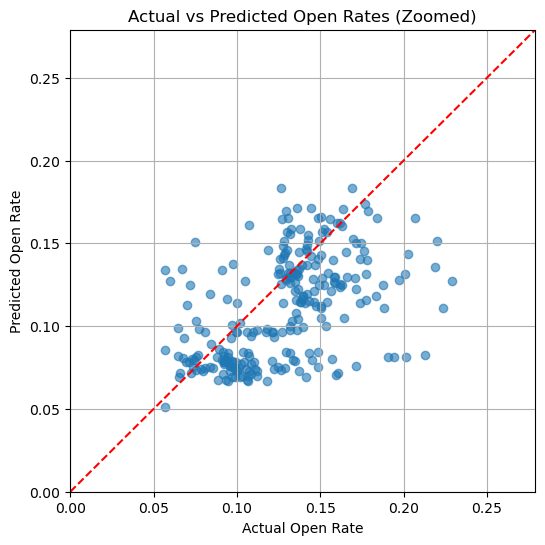

In [34]:
# --- 9. plots (zoomed because your data < 0.5 mostly) ---
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
max_val = max(y_true.max(), y_pred.max())
upper_limit = min(0.6, float(round(max_val + 0.05, 3)))
plt.plot([0, upper_limit], [0, upper_limit], 'r--')
plt.xlim(0, upper_limit)
plt.ylim(0, upper_limit)
plt.xlabel('Actual Open Rate')
plt.ylabel('Predicted Open Rate')
plt.title('Actual vs Predicted Open Rates (Zoomed)')
plt.grid(True)
plt.show()

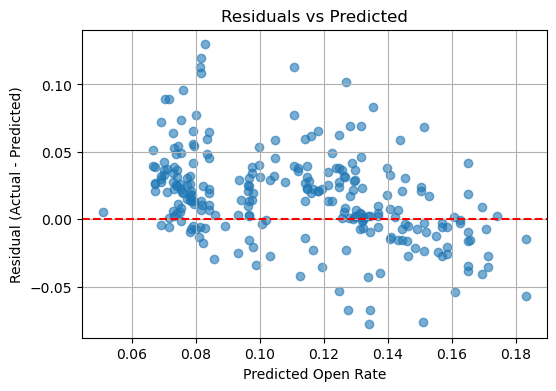

In [35]:
# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Open Rate')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

In [36]:
import pandas as pd
import numpy as np

# Extract coefficients and related stats
coef_df = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Std_Err': result.bse.values,
    'p_value': result.pvalues.values
})

# Add Odds Ratios (exp(coefficient))
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

# Sort by absolute impact
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Keep top 20 (excluding intercept)
top20 = coef_df[coef_df['Feature'] != 'const'].head(20)

# Display nicely formatted
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n📊 Top 20 Most Important Features (by absolute coefficient size):\n")
print(top20)




📊 Top 20 Most Important Features (by absolute coefficient size):

                      Feature  Coefficient  Std_Err  p_value  Odds_Ratio
8   Category_name_NL Interval       0.5478   0.0066   0.0000      1.7294
17    Length_Of_subject_short      -0.5301   0.0032   0.0000      0.5885
14      Price_or_Discount_yes      -0.4632   0.0015   0.0000      0.6293
12                Urgency_yes      -0.4229   0.0013   0.0000      0.6552
3        Day_of_week_Saturday       0.3072   0.0054   0.0000      1.3596
2          Day_of_week_Monday       0.2788   0.0050   0.0000      1.3215
5        Day_of_week_Thursday       0.2609   0.0050   0.0000      1.2981
7       Day_of_week_Wednesday       0.2582   0.0015   0.0000      1.2946
9             Main_Vs_REM_REM       0.2361   0.0083   0.0000      1.2663
15        Imperative_Tone_yes      -0.2022   0.0029   0.0000      0.8169
10        Personalization_yes      -0.1237   0.0089   0.0000      0.8836
21              Month_January       0.1171   0.0025   0.0

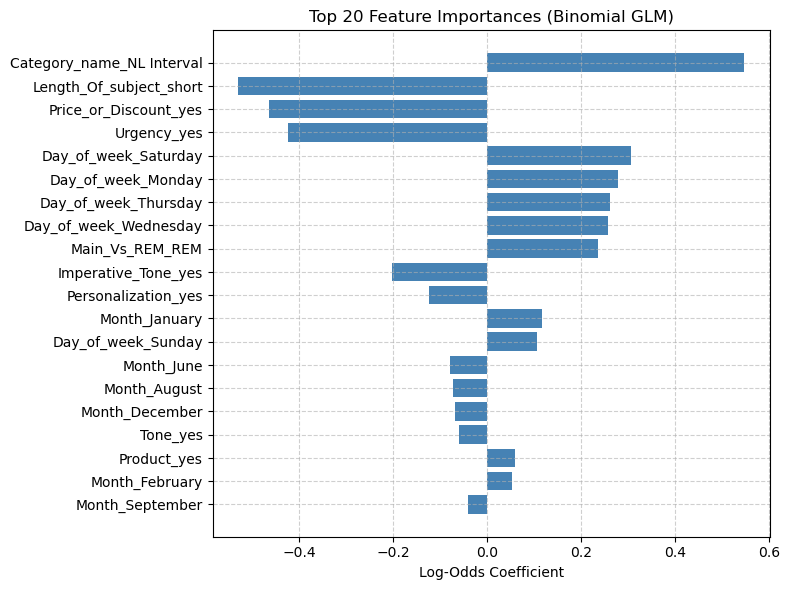

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(top20['Feature'], top20['Coefficient'], color='steelblue')
plt.xlabel('Log-Odds Coefficient')
plt.title('Top 20 Feature Importances (Binomial GLM)')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



C:\Users\TOWER-PC\AppData\Local\Temp\ipykernel_11116\1161176239.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_cal.groupby('bin').agg(


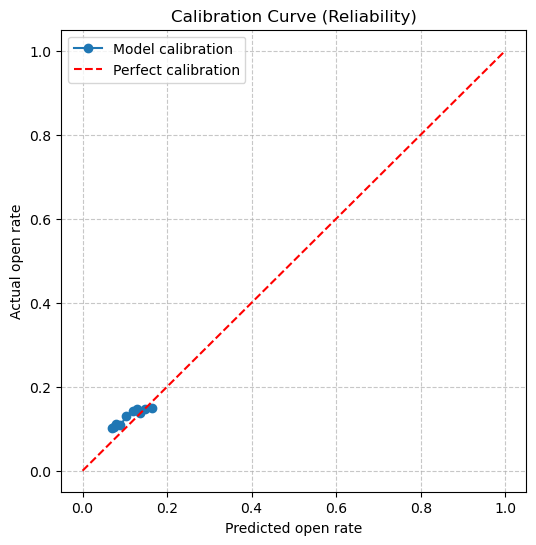


📏 Mean Absolute Error (MAE): 0.0283

🚀 Top-decile lift: 1.18x
   (Top 10% avg open rate = 0.151, overall avg = 0.128)

📊 Top 20 Drivers (with 95% Confidence Intervals):

                      Feature  Coefficient  Lower_CI  Upper_CI  Odds_Ratio  \
8   Category_name_NL Interval       0.5478    0.5347    0.5608      1.7294   
17    Length_Of_subject_short      -0.5301   -0.5363   -0.5239      0.5885   
14      Price_or_Discount_yes      -0.4632   -0.4662   -0.4601      0.6293   
12                Urgency_yes      -0.4229   -0.4254   -0.4204      0.6552   
3        Day_of_week_Saturday       0.3072    0.2966    0.3178      1.3596   
2          Day_of_week_Monday       0.2788    0.2690    0.2885      1.3215   
5        Day_of_week_Thursday       0.2609    0.2510    0.2708      1.2981   
7       Day_of_week_Wednesday       0.2582    0.2552    0.2612      1.2946   
9             Main_Vs_REM_REM       0.2361    0.2198    0.2524      1.2663   
15        Imperative_Tone_yes      -0.2022   -0.2

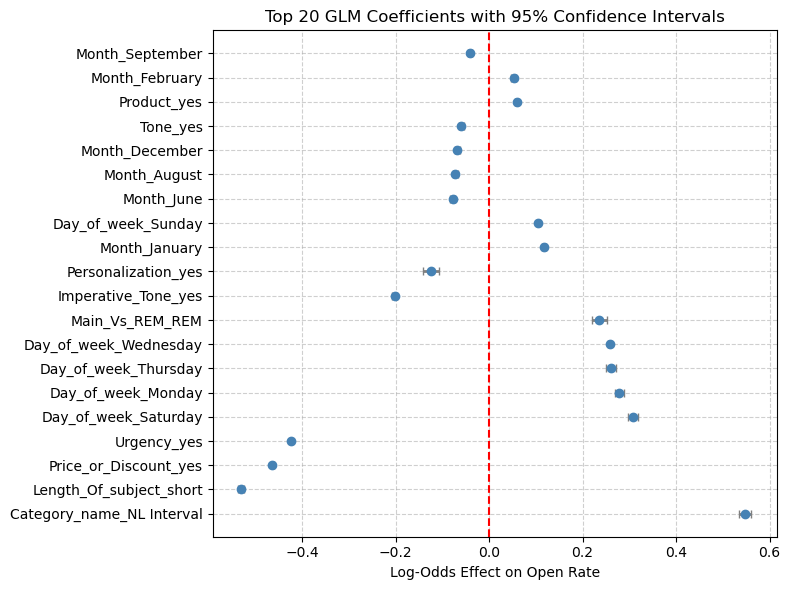

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# ========== 1️⃣ CALIBRATION CURVE (reliability plot) ==========

y_true = test_df['OR']        # actual open rate
y_pred = test_df['pred_open_rate']  # predicted open rate (probability)

# Remove NaNs for safe plotting
mask = (~y_true.isna()) & (~y_pred.isna())
y_true = y_true[mask]
y_pred = y_pred[mask]

# ✅ FIX: manual calibration for continuous proportions
df_cal = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df_cal['bin'] = pd.qcut(df_cal['y_pred'], q=10, duplicates='drop')

calibration = df_cal.groupby('bin').agg(
    prob_pred=('y_pred', 'mean'),
    prob_true=('y_true', 'mean'),
    count=('y_true', 'size')
).reset_index()

plt.figure(figsize=(6, 6))
plt.plot(calibration['prob_pred'], calibration['prob_true'], 'o-', label='Model calibration')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')
plt.xlabel('Predicted open rate')
plt.ylabel('Actual open rate')
plt.title('Calibration Curve (Reliability)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ========== 2️⃣ MAE ==========
mae = mean_absolute_error(y_true, y_pred)
print(f"\n📏 Mean Absolute Error (MAE): {mae:.4f}")

# ========== 3️⃣ TOP-DECILE LIFT ==========
df_eval = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df_eval = df_eval.sort_values('y_pred', ascending=False)
cutoff = int(0.1 * len(df_eval))

overall_mean = df_eval['y_true'].mean()
top_decile_mean = df_eval.head(cutoff)['y_true'].mean()
lift = top_decile_mean / overall_mean

print(f"\n🚀 Top-decile lift: {lift:.2f}x")
print(f"   (Top 10% avg open rate = {top_decile_mean:.3f}, overall avg = {overall_mean:.3f})")

# ========== 4️⃣ DRIVERS (GLM coefficients with 95% CI) ==========
coef_summary = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Std_Err': result.bse.values,
    'p_value': result.pvalues.values
})
coef_summary['Lower_CI'] = coef_summary['Coefficient'] - 1.96 * coef_summary['Std_Err']
coef_summary['Upper_CI'] = coef_summary['Coefficient'] + 1.96 * coef_summary['Std_Err']
coef_summary['Odds_Ratio'] = np.exp(coef_summary['Coefficient'])
coef_summary['Lower_OR'] = np.exp(coef_summary['Lower_CI'])
coef_summary['Upper_OR'] = np.exp(coef_summary['Upper_CI'])

coef_summary = coef_summary.reindex(coef_summary['Coefficient'].abs().sort_values(ascending=False).index)
top_coef = coef_summary[coef_summary['Feature'] != 'const'].head(20)

print("\n📊 Top 20 Drivers (with 95% Confidence Intervals):\n")
print(top_coef[['Feature', 'Coefficient', 'Lower_CI', 'Upper_CI', 'Odds_Ratio', 'p_value']])

# ========== 5️⃣ OPTIONAL: Visualize Drivers ==========
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=top_coef['Coefficient'],
    y=top_coef['Feature'],
    xerr=1.96 * top_coef['Std_Err'],
    fmt='o', color='steelblue', ecolor='gray', elinewidth=2, capsize=3
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Top 20 GLM Coefficients with 95% Confidence Intervals')
plt.xlabel('Log-Odds Effect on Open Rate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Now I will build a base line LightGBM

In [39]:
X_train_const.columns

Index(['const', 'Letter_Count', 'Day_of_week_Monday', 'Day_of_week_Saturday',
       'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday',
       'Day_of_week_Wednesday', 'Category_name_NL Interval', 'Main_Vs_REM_REM',
       'Personalization_yes', 'Emoji_yes', 'Urgency_yes', 'Tone_yes',
       'Price_or_Discount_yes', 'Imperative_Tone_yes', 'Product_yes',
       'Length_Of_subject_short', 'Month_August', 'Month_December',
       'Month_February', 'Month_January', 'Month_July', 'Month_June',
       'Month_March', 'Month_May', 'Month_November', 'Month_October',
       'Month_September'],
      dtype='object')

In [40]:


import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

def interactive_open_rate_predictor_glm(result):
    """
    Interactive predictor for Open Rate using GLM binomial model.
    Allows user to input key features (including Sendings).
    """

    # === Define feature options ===
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday']
    categories = ['NL Interval']
    main_rem = ['REM', 'Main']
    yes_no = ['yes', 'no']
    lengths = ['short']
    months = [
        'January', 'February', 'March', 'May', 'June', 'July', 'August',
        'September', 'October', 'November', 'December'
    ]

    # === Prediction function ===
    def _predict(
        Letter_Count,
        Day_of_week,
        Category_name,
        Main_Vs_REM,
        Personalization,
        Emoji,
        Urgency,
        Tone,
        Price_or_Discount,
        Imperative_Tone,
        Product,
        Length_Of_subject,
        Month,
        Sendings
    ):
        # Create a row matching model columns
        X_input = pd.DataFrame(columns=result.params.index)
        X_input.loc[0] = 0  # initialize all 0
        X_input['const'] = 1
        X_input['Letter_Count'] = Letter_Count

        # Encode categorical selections
        X_input[f'Day_of_week_{Day_of_week}'] = 1
        X_input[f'Category_name_{Category_name}'] = 1
        X_input[f'Main_Vs_REM_{Main_Vs_REM}'] = 1
        X_input[f'Personalization_{Personalization}'] = 1
        X_input[f'Emoji_{Emoji}'] = 1
        X_input[f'Urgency_{Urgency}'] = 1
        X_input[f'Tone_{Tone}'] = 1
        X_input[f'Price_or_Discount_{Price_or_Discount}'] = 1
        X_input[f'Imperative_Tone_{Imperative_Tone}'] = 1
        X_input[f'Product_{Product}'] = 1
        X_input[f'Length_Of_subject_{Length_Of_subject}'] = 1
        X_input[f'Month_{Month}'] = 1

        # Add Sendings as numeric predictor
        X_input['Sendings'] = Sendings

        # Align columns (fill any missing)
        for col in result.params.index:
            if col not in X_input.columns:
                X_input[col] = 0
        X_input = X_input[result.params.index]

        # Predict open rate
        pred_rate = result.predict(X_input)[0]
        print(f"\n📧 Predicted Open Rate: {pred_rate:.3f} ({pred_rate*100:.1f}%)")

    # === Build the interactive UI ===
    interact(
        _predict,
        Letter_Count=widgets.IntSlider(value=40, min=10, max=100, step=1, description='Letter Count'),
        Day_of_week=widgets.Dropdown(options=days, description='Day'),
        Category_name=widgets.Dropdown(options=categories, description='Category'),
        Main_Vs_REM=widgets.Dropdown(options=main_rem, description='Main/REM'),
        Personalization=widgets.Dropdown(options=yes_no, description='Personalization'),
        Emoji=widgets.Dropdown(options=yes_no, description='Emoji'),
        Urgency=widgets.Dropdown(options=yes_no, description='Urgency'),
        Tone=widgets.Dropdown(options=yes_no, description='Tone'),
        Price_or_Discount=widgets.Dropdown(options=yes_no, description='Price/Discount'),
        Imperative_Tone=widgets.Dropdown(options=yes_no, description='Imperative'),
        Product=widgets.Dropdown(options=['yes'], description='Product'),
        Length_Of_subject=widgets.Dropdown(options=lengths, description='Length'),
        Month=widgets.Dropdown(options=months, description='Month'),
        Sendings=widgets.IntSlider(value=3000, min=100, max=10000, step=100, description='Sendings')
    )



In [42]:
interactive_open_rate_predictor_glm(result)


interactive(children=(IntSlider(value=40, description='Letter Count', min=10), Dropdown(description='Day', opt…

In [ ]:
! pip install lightgbm

In [ ]:
# === Requirements ===
# pandas, numpy, matplotlib, sklearn, statsmodels, lightgbm
# pip install pandas numpy matplotlib scikit-learn statsmodels lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# -----------------------------
# 0. quick checks / rename if needed
# -----------------------------
# Change these if your column names differ:
TARGET = "OR"               # proportion 0..1
DATE_COL = "Sent_Date"
WEIGHT_COL = "Sendings"

# -----------------------------
# 1. Prepare X, y and time-split
# -----------------------------
# Make sure date is datetime
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

# Sort by date
df = df.sort_values(DATE_COL).reset_index(drop=True)

# Create X (features) and y
X_all = df.drop(columns=[TARGET, WEIGHT_COL, DATE_COL])
y_all = df[TARGET]
w_all = df[WEIGHT_COL]

# Ensure numeric dtype
X_all = X_all.apply(pd.to_numeric, errors='coerce').fillna(0.0)

# Time-based split: 80% oldest -> train, 20% newest -> test
split_date = df[DATE_COL].quantile(0.8)
train_mask = df[DATE_COL] <= split_date
test_mask  = df[DATE_COL] > split_date

X_train = X_all.loc[train_mask].copy()
X_test  = X_all.loc[test_mask].copy()
y_train = y_all.loc[train_mask].copy()
y_test  = y_all.loc[test_mask].copy()
w_train = w_all.loc[train_mask].copy()
w_test  = w_all.loc[test_mask].copy()

# Convert all data to float type
X_train = X_train.astype(float)
X_test = X_test.astype(float)
w_test = w_test.astype (float)
# Add intercept for GLM
X_train_glm = sm.add_constant(X_train, has_constant='add')
X_test_glm  = sm.add_constant(X_test,  has_constant='add')

# -----------------------------
# 2. Fit a Binomial GLM (unregularized)
# -----------------------------
glm = sm.GLM(y_train, X_train_glm, family=sm.families.Binomial(), freq_weights=w_train)
glm_res = glm.fit()   # might raise if perfectly collinear columns exist

# Predictions
y_pred_glm = glm_res.predict(X_test_glm)

# -----------------------------
# 3. Fit an ML model (LightGBM) for comparison & permutation importance
# -----------------------------
lgb = LGBMRegressor(objective="regression", n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
# fit using sample_weight = sending volume to reflect importance
lgb.fit(X_train, y_train, sample_weight=w_train)
y_pred_lgb = lgb.predict(X_test)

# -----------------------------
# 4. Metrics: MAE (weighted & unweighted), RMSE, R2
# -----------------------------
def weighted_mae(y_true, y_pred, w):
    return (np.abs(y_true - y_pred) * w).sum() / w.sum()

def weighted_rmse(y_true, y_pred, w):
    return np.sqrt(((y_true - y_pred)**2 * w).sum() / w.sum())

print("\n=== GLM Performance on holdout ===")
print("MAE (unweighted):", mean_absolute_error(y_test, y_pred_glm))
print("MAE (weighted by sends):", weighted_mae(y_test.values, y_pred_glm, w_test.values))
print("RMSE (unweighted):", np.sqrt(mean_squared_error(y_test, y_pred_glm)))
print("RMSE (weighted):", weighted_rmse(y_test.values, y_pred_glm, w_test.values))
print("R² (unweighted):", r2_score(y_test, y_pred_glm))

print("\n=== LightGBM Performance on holdout ===")
print("MAE (unweighted):", mean_absolute_error(y_test, y_pred_lgb))
print("MAE (weighted by sends):", weighted_mae(y_test.values, y_pred_lgb, w_test.values))
print("RMSE (unweighted):", np.sqrt(mean_squared_error(y_test, y_pred_lgb)))
print("RMSE (weighted):", weighted_rmse(y_test.values, y_pred_lgb, w_test.values))
print("R² (unweighted):", r2_score(y_test, y_pred_lgb))

# -----------------------------
# 5. Calibration (reliability curve) — weighted by sends
# -----------------------------
def weighted_reliability(y_true, y_pred, weights=None, n_bins=10):
    df_tmp = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "w": weights if weights is not None else 1.0})
    df_tmp["bin"] = pd.qcut(df_tmp["y_pred"], q=n_bins, duplicates='drop')
    grouped = df_tmp.groupby("bin").apply(lambda g: pd.Series({
        "mean_pred": np.average(g["y_pred"], weights=g["w"]),
        "frac_actual": np.average(g["y_true"], weights=g["w"]),
        "sum_w": g["w"].sum(),
        "count": len(g)
    }))
    grouped = grouped.sort_values("mean_pred")
    return grouped

calib_glm = weighted_reliability(y_test.values, y_pred_glm, weights=w_test.values, n_bins=10)
calib_lgb = weighted_reliability(y_test.values, y_pred_lgb, weights=w_test.values, n_bins=10)

# Plot calibration
plt.figure(figsize=(6,6))
plt.plot(calib_glm["mean_pred"], calib_glm["frac_actual"], marker='o', label='GLM (weighted bins)')
plt.plot(calib_lgb["mean_pred"], calib_lgb["frac_actual"], marker='o', label='LightGBM (weighted bins)')
plt.plot([0,1],[0,1],'k--', label='Perfect calibration')
plt.xlabel("Mean predicted OR (bin)")
plt.ylabel("Weighted actual OR (bin)")
plt.title("Calibration / Reliability Curve (weighted by sends)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 6. Top-decile lift
#    - compute both unweighted and weighted top-decile lift
# -----------------------------
def top_decile_lift(y_true, y_pred, weights=None):
    df_tmp = pd.DataFrame({"y": y_true, "pred": y_pred, "w": weights if weights is not None else 1.0})
    # sort by predicted
    df_tmp = df_tmp.sort_values("pred", ascending=False).reset_index(drop=True)
    cutoff = int(np.ceil(0.10 * len(df_tmp)))
    top = df_tmp.iloc[:cutoff]
    overall = df_tmp
    # unweighted averages
    avg_top_unw = top["y"].mean()
    avg_overall_unw = overall["y"].mean()
    lift_unw = avg_top_unw / avg_overall_unw if avg_overall_unw != 0 else np.nan
    # weighted averages
    avg_top_w = (top["y"] * top["w"]).sum() / top["w"].sum()
    avg_overall_w = (overall["y"] * overall["w"]).sum() / overall["w"].sum()
    lift_w = avg_top_w / avg_overall_w if avg_overall_w != 0 else np.nan
    return {
        "top_mean_unweighted": avg_top_unw,
        "overall_mean_unweighted": avg_overall_unw,
        "lift_unweighted": lift_unw,
        "top_mean_weighted": avg_top_w,
        "overall_mean_weighted": avg_overall_w,
        "lift_weighted": lift_w
    }

print("\n=== Top-decile lift (GLM predictions) ===")
print(top_decile_lift(y_test.values, y_pred_glm, weights=w_test.values))
print("\n=== Top-decile lift (LightGBM predictions) ===")
print(top_decile_lift(y_test.values, y_pred_lgb, weights=w_test.values))

# -----------------------------
# 7. Permutation importance on holdout for ML model (LightGBM)
# -----------------------------
perm = permutation_importance(lgb, X_test, y_test, n_repeats=30, random_state=42, scoring='r2')
perm_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print("\n=== Top 20 Permutation Importances (LightGBM) ===")
print(perm_df.head(20))

# Plot top 20
topn = 20
plt.figure(figsize=(8,6))
plt.barh(perm_df["feature"].head(topn)[::-1], perm_df["importance_mean"].head(topn)[::-1])
plt.xlabel("Permutation importance (mean Δ R²)")
plt.title("Permutation Importance (LightGBM) — holdout")
plt.grid(axis='x')
plt.show()

# -----------------------------
# 8. GLM coefficients with 95% CIs
# -----------------------------
# model summary already in glm_res
coef = glm_res.params
se = glm_res.bse
ci = glm_res.conf_int(alpha=0.05)
coef_df = pd.DataFrame({
    "feature": coef.index,
    "coef": coef.values,
    "se": se.values,
    "ci_lower": ci[0].values,
    "ci_upper": ci[1].values,
    "p_value": glm_res.pvalues
}).sort_values(by="coef", key=lambda s: np.abs(s), ascending=False)

print("\n=== Top 30 GLM coefficients (abs sorted) with 95% CI ===")
print(coef_df.head(30))

# Plot coefficients with CI (top 25 by absolute coef)
nplot = min(25, len(coef_df))
plot_df = coef_df.head(nplot).iloc[::-1]  # reverse for plotting
plt.figure(figsize=(8, nplot*0.35 + 1))
plt.errorbar(plot_df["coef"], plot_df["feature"], 
             xerr=1.96*plot_df["se"], fmt='o', capsize=3)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Coefficient (log-odds)")
plt.title("GLM coefficients with 95% CIs")
plt.grid(axis='x')
plt.show()


